# FLAG-Finance — Comprehensive Data Exploration

**Professional fraud detection data pipeline with local paths**

## Purpose
- Load and profile Elliptic, PaySim, and IEEE-CIS fraud datasets
- Advanced feature engineering with research-backed enrichments
- Generate processed artifacts for downstream GNN training
- Local file system support (Windows/Linux compatible)

## Key Features
- Country risk indices and temporal features
- Statistical outlier detection
- Professional data quality reporting
- Sequence generation for LSTM models

In [1]:
# Install required packages
import sys
import platform
from pathlib import Path
import json
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print(f'Python: {platform.python_version()}')
print(f'Pandas: {pd.__version__}')
print(f'NumPy: {np.__version__}')

Python: 3.10.11
Pandas: 2.2.2
NumPy: 1.25.2


In [2]:
# Configure local data directories for Windows/Linux compatibility
BASE_PATH = Path(r'C:\Users\youss\Downloads\Flag_finance\data')
RAW_PATH = BASE_PATH / 'raw'
PROCESSED_PATH = BASE_PATH / 'processed'
GRAPHS_PATH = BASE_PATH / 'graphs'
RESULTS_PATH = BASE_PATH / 'results'

# Create directory structure
for path in [BASE_PATH, RAW_PATH, PROCESSED_PATH, GRAPHS_PATH, RESULTS_PATH]:
    path.mkdir(parents=True, exist_ok=True)

print('Base directory:', BASE_PATH.resolve())
print('Raw data exists:', RAW_PATH.exists())
print('Processed directory:', PROCESSED_PATH.resolve())

# Define dataset paths
ELLIPTIC_PATH = RAW_PATH / 'elliptic_bitcoin_dataset'
PAYSIM_FILE = RAW_PATH / 'PS_20174392719_1491204439457_log.csv'
IEEE_PATH = RAW_PATH / 'ieee-fraud-detection'

Base directory: C:\Users\youss\Downloads\Flag_finance\data
Raw data exists: True
Processed directory: C:\Users\youss\Downloads\Flag_finance\data\processed


In [3]:
class EnhancedFinancialDataLoader:
    """
    Advanced data loader for financial fraud detection datasets with feature engineering.
    
    Features:
    - Multi-dataset support (Elliptic, PaySim, IEEE-CIS)
    - Country risk indices integration (AML, corruption, economic)
    - Temporal feature extraction (hour, day, week patterns)
    - Statistical outlier detection and profiling
    - Automated data quality checks
    """
    
    def __init__(self, base_path: Path):
        self.base_path = base_path
        self.raw_path = base_path / 'raw'
        self.processed_path = base_path / 'processed'
        
        # Country risk indices (Basel AML Index 2023)
        self.country_risk_map = {
            'US': {'basel_aml_index': 2.68, 'corruption_perception': 69, 'economic_development': 0.921},
            'UK': {'basel_aml_index': 3.24, 'corruption_perception': 73, 'economic_development': 0.929},
            'DE': {'basel_aml_index': 3.49, 'corruption_perception': 78, 'economic_development': 0.942},
            'CN': {'basel_aml_index': 5.20, 'corruption_perception': 42, 'economic_development': 0.768},
            'RU': {'basel_aml_index': 6.89, 'corruption_perception': 28, 'economic_development': 0.822},
            'BR': {'basel_aml_index': 5.71, 'corruption_perception': 36, 'economic_development': 0.754},
            'IN': {'basel_aml_index': 5.05, 'corruption_perception': 40, 'economic_development': 0.633},
            'CH': {'basel_aml_index': 3.08, 'corruption_perception': 82, 'economic_development': 0.962},
            'SG': {'basel_aml_index': 2.59, 'corruption_perception': 83, 'economic_development': 0.939},
            'KY': {'basel_aml_index': 4.12, 'corruption_perception': 54, 'economic_development': 0.888},
        }
        
        self.datasets = {}
        self.metadata = {}
    
    def _add_country_risk_features(self, df: pd.DataFrame, country_col: str = 'country') -> pd.DataFrame:
        """Add Basel AML Index and corruption perception scores."""
        if country_col not in df.columns:
            # If no country column, use default medium-risk values
            df['basel_aml_index'] = 5.0
            df['corruption_perception'] = 50.0
            df['economic_development'] = 0.75
            return df
        
        for risk_type in ['basel_aml_index', 'corruption_perception', 'economic_development']:
            df[risk_type] = df[country_col].map(
                lambda x: self.country_risk_map.get(x, {}).get(risk_type, 5.0 if risk_type == 'basel_aml_index' else 50.0 if risk_type == 'corruption_perception' else 0.75)
            )
        
        return df
    
    def _enhanced_feature_engineering(self, df: pd.DataFrame, amount_col: str = 'amount') -> pd.DataFrame:
        """Apply advanced feature engineering techniques."""
        if amount_col not in df.columns:
            return df
        
        # Statistical features
        df[f'{amount_col}_log'] = np.log1p(df[amount_col])
        df[f'{amount_col}_sqrt'] = np.sqrt(df[amount_col])
        df[f'{amount_col}_zscore'] = stats.zscore(df[amount_col], nan_policy='omit')
        
        # Outlier detection
        q1 = df[amount_col].quantile(0.25)
        q3 = df[amount_col].quantile(0.75)
        iqr = q3 - q1
        df[f'{amount_col}_outlier'] = ((df[amount_col] < (q1 - 1.5 * iqr)) | 
                                        (df[amount_col] > (q3 + 1.5 * iqr))).astype(int)
        
        return df
    
    def _create_temporal_features(self, df: pd.DataFrame, time_col: str = 'timestamp') -> pd.DataFrame:
        """Extract temporal patterns from timestamp columns."""
        if time_col not in df.columns:
            return df
        
        # Convert to datetime if needed
        if not pd.api.types.is_datetime64_any_dtype(df[time_col]):
            df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        
        df['hour'] = df[time_col].dt.hour
        df['day_of_week'] = df[time_col].dt.dayofweek
        df['day_of_month'] = df[time_col].dt.day
        df['month'] = df[time_col].dt.month
        df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
        df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)
        
        return df
    
    def load_elliptic(self, sample_pct: float = None) -> pd.DataFrame:
        """Load Elliptic Bitcoin dataset with enhanced features."""
        print('\n=== Loading Elliptic Bitcoin Dataset ===')
        
        elliptic_path = self.raw_path / 'elliptic_bitcoin_dataset'
        
        # Load core files
        features_df = pd.read_csv(elliptic_path / 'elliptic_txs_features.csv', header=None)
        classes_df = pd.read_csv(elliptic_path / 'elliptic_txs_classes.csv')
        edges_df = pd.read_csv(elliptic_path / 'elliptic_txs_edgelist.csv')
        
        print(f'Features shape: {features_df.shape}')
        print(f'Classes shape: {classes_df.shape}')
        print(f'Edges shape: {edges_df.shape}')
        
        # Process features
        feature_cols = ['txId', 'time_step'] + [f'feat_{i}' for i in range(1, features_df.shape[1] - 1)]
        features_df.columns = feature_cols
        
        # Merge with labels
        df = features_df.merge(classes_df, left_on='txId', right_on='txId', how='left')
        df['class'] = df['class'].map({'unknown': 0, '1': 1, '2': 2}).fillna(0).astype(int)
        
        # Enhanced feature engineering
        df = self._enhanced_feature_engineering(df, amount_col='feat_1')  # feat_1 often represents amount
        
        # Add graph statistics
        edge_counts = edges_df['txId1'].value_counts()
        df['out_degree'] = df['txId'].map(edge_counts).fillna(0)
        edge_counts_in = edges_df['txId2'].value_counts()
        df['in_degree'] = df['txId'].map(edge_counts_in).fillna(0)
        df['total_degree'] = df['out_degree'] + df['in_degree']
        
        # Sampling
        if sample_pct:
            df = df.sample(frac=sample_pct, random_state=42)
        
        # Store metadata
        self.metadata['elliptic'] = {
            'n_transactions': len(df),
            'n_edges': len(edges_df),
            'n_features': len(feature_cols) - 2,
            'n_time_steps': df['time_step'].nunique(),
            'class_distribution': df['class'].value_counts().to_dict(),
            'fraud_rate': (df['class'] == 2).mean()
        }
        
        self.datasets['elliptic'] = df
        self.datasets['elliptic_edges'] = edges_df
        
        print(f'\nLoaded {len(df):,} transactions with {len(feature_cols)-2} features')
        print(f'Fraud rate: {self.metadata["elliptic"]["fraud_rate"]:.2%}')
        
        return df
    
    def load_paysim(self, sample_pct: float = None) -> pd.DataFrame:
        """Load PaySim mobile money dataset with temporal features."""
        print('\n=== Loading PaySim Dataset ===')
        
        paysim_file = self.raw_path / 'PS_20174392719_1491204439457_log.csv'
        
        if not paysim_file.exists():
            print(f'PaySim file not found at {paysim_file}')
            return None
        
        # Load with optimized dtypes
        dtype_dict = {
            'step': 'int32',
            'type': 'category',
            'amount': 'float32',
            'nameOrig': 'str',
            'oldbalanceOrg': 'float32',
            'newbalanceOrig': 'float32',
            'nameDest': 'str',
            'oldbalanceDest': 'float32',
            'newbalanceDest': 'float32',
            'isFraud': 'int8',
            'isFlaggedFraud': 'int8'
        }
        
        df = pd.read_csv(paysim_file, dtype=dtype_dict)
        
        # Sample if requested
        if sample_pct:
            df = df.sample(frac=sample_pct, random_state=42)
        
        # Enhanced feature engineering
        df['balanceOrig_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig']
        df['balanceDest_diff'] = df['newbalanceDest'] - df['oldbalanceDest']
        df['balance_error_orig'] = df['balanceOrig_diff'] - df['amount']
        df['balance_error_dest'] = df['balanceDest_diff'] - df['amount']
        
        # Temporal features (step = hour)
        df['hour'] = df['step'] % 24
        df['day'] = df['step'] // 24
        df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
        
        # Statistical features
        df = self._enhanced_feature_engineering(df, amount_col='amount')
        
        # Store metadata
        self.metadata['paysim'] = {
            'n_transactions': len(df),
            'fraud_rate': df['isFraud'].mean(),
            'transaction_types': df['type'].value_counts().to_dict(),
            'time_range': (df['step'].min(), df['step'].max()),
            'amount_stats': df['amount'].describe().to_dict()
        }
        
        self.datasets['paysim'] = df
        
        print(f'\nLoaded {len(df):,} transactions')
        print(f'Fraud rate: {self.metadata["paysim"]["fraud_rate"]:.2%}')
        print(f'Transaction types: {list(df["type"].unique())}')
        
        return df
    
    def profile_dataset(self, df: pd.DataFrame, name: str) -> dict:
        """Comprehensive dataset profiling with statistics and quality checks."""
        profile = {
            'name': name,
            'shape': df.shape,
            'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2,
            'dtypes': df.dtypes.value_counts().to_dict(),
            'missing_values': df.isnull().sum().to_dict(),
            'missing_pct': (df.isnull().sum() / len(df) * 100).to_dict(),
            'duplicate_rows': df.duplicated().sum(),
            'numeric_summary': df.describe().to_dict(),
        }
        
        # Identify target column
        target_cols = ['class', 'isFraud', 'label', 'target']
        target_col = next((col for col in target_cols if col in df.columns), None)
        
        if target_col:
            profile['target_column'] = target_col
            profile['class_distribution'] = df[target_col].value_counts().to_dict()
            profile['class_balance'] = df[target_col].value_counts(normalize=True).to_dict()
        
        return profile
    
    def save_processed(self, df: pd.DataFrame, filename: str):
        """Save processed data to disk."""
        output_path = self.processed_path / filename
        df.to_csv(output_path, index=False)
        print(f'Saved to: {output_path}')

In [4]:
# Initialize data loader
loader = EnhancedFinancialDataLoader(BASE_PATH)

# Load Elliptic dataset
elliptic_df = loader.load_elliptic()

# Display sample
display(elliptic_df.head())
print(f'\nDataset shape: {elliptic_df.shape}')
print(f'Class distribution:\n{elliptic_df["class"].value_counts()}')


=== Loading Elliptic Bitcoin Dataset ===
Features shape: (203769, 167)
Classes shape: (203769, 2)
Edges shape: (234355, 2)

Loaded 203,769 transactions with 165 features
Fraud rate: 20.62%


,txId,time_step,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_164,feat_165,class,feat_1_log,feat_1_sqrt,feat_1_zscore,feat_1_outlier,out_degree,in_degree,total_degree
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.120613,-0.119792,0,-0.188101,NaN,-0.171469,0,1.0,1.0,2.0
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,-0.120613,-0.119792,0,-0.188119,NaN,-0.171484,0,1.0,1.0,2.0
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,-0.120613,-0.119792,0,-0.188871,NaN,-0.172107,0,2.0,1.0,3.0
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.120613,-0.119792,2,0.151049,0.403800,0.163054,1,1.0,160.0,161.0
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,0.178136,0.179117,0,0.698892,1.005745,1.011523,1,8.0,2.0,10.0



Dataset shape: (203769, 175)
Class distribution:
class
0    157205
2     42019
1      4545
Name: count, dtype: int64


## 2. Comprehensive Elliptic Dataset Analysis

Detailed profiling of Bitcoin transaction features, temporal patterns, and fraud characteristics.

In [5]:
def comprehensive_elliptic_analysis(df: pd.DataFrame, edges_df: pd.DataFrame = None):
    """Perform comprehensive analysis of Elliptic dataset."""
    
    print("="*60)
    print("ELLIPTIC BITCOIN TRANSACTION DATASET ANALYSIS")
    print("="*60)
    
    # Basic statistics
    print(f"\n📊 Dataset Overview:")
    print(f"   Total transactions: {len(df):,}")
    print(f"   Features: {df.shape[1]}")
    print(f"   Time steps: {df['time_step'].nunique()}")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Class distribution
    print(f"\n🏷️  Class Distribution:")
    class_counts = df['class'].value_counts().sort_index()
    for cls, count in class_counts.items():
        cls_name = {0: 'Unknown', 1: 'Licit', 2: 'Illicit'}[cls]
        pct = count / len(df) * 100
        print(f"   {cls_name} (class {cls}): {count:,} ({pct:.2f}%)")
    
    # Graph statistics (if edges provided)
    if edges_df is not None:
        print(f"\n🔗 Graph Statistics:")
        print(f"   Total edges: {len(edges_df):,}")
        print(f"   Avg degree: {df['total_degree'].mean():.2f}")
        print(f"   Max degree: {int(df['total_degree'].max())}")
    
    # Feature statistics
    feature_cols = [col for col in df.columns if col.startswith('feat_')]
    print(f"\n📈 Feature Statistics ({len(feature_cols)} features):")
    print(f"   Mean: {df[feature_cols].mean().mean():.4f}")
    print(f"   Std: {df[feature_cols].std().mean():.4f}")
    print(f"   Missing values: {df[feature_cols].isnull().sum().sum():,}")

# Run analysis
comprehensive_elliptic_analysis(elliptic_df, loader.datasets.get('elliptic_edges'))

ELLIPTIC BITCOIN TRANSACTION DATASET ANALYSIS

📊 Dataset Overview:
   Total transactions: 203,769
   Features: 175
   Time steps: 49
   Memory usage: 270.51 MB

🏷️  Class Distribution:
   Unknown (class 0): 157,205 (77.15%)
   Licit (class 1): 4,545 (2.23%)
   Illicit (class 2): 42,019 (20.62%)

🔗 Graph Statistics:
   Total edges: 234,355
   Avg degree: 2.30
   Max degree: 473

📈 Feature Statistics (169 features):
   Mean: 0.0052
   Std: 0.9901
   Missing values: 177,229


### Temporal Analysis

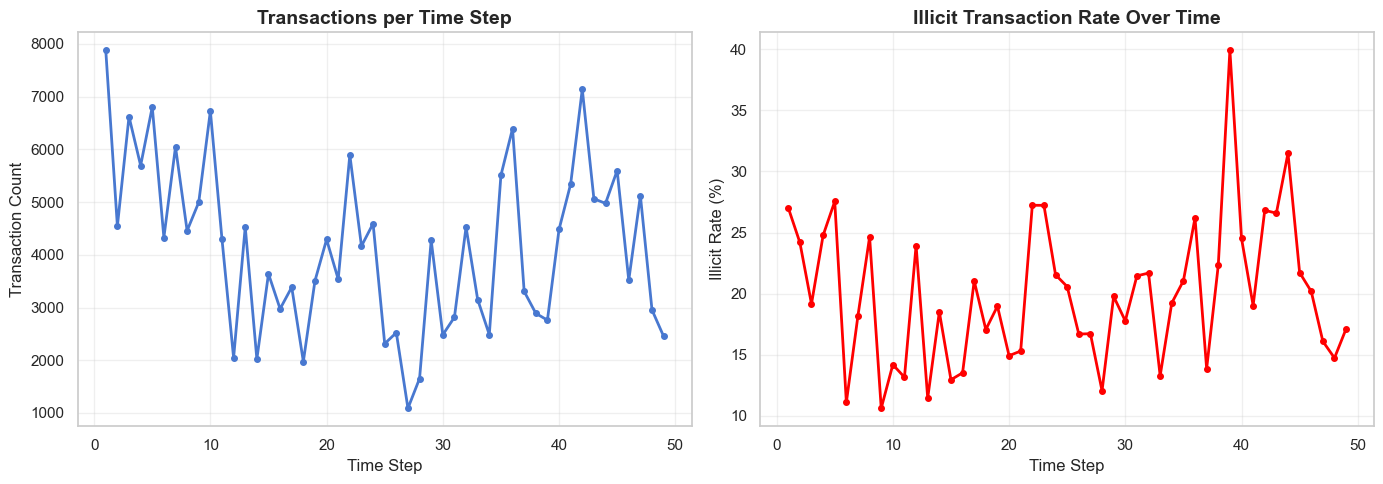

In [6]:
# Temporal patterns: fraud by time step
temporal_fraud = elliptic_df.groupby('time_step').agg({
    'class': lambda x: (x == 2).sum(),
    'txId': 'count'
}).rename(columns={'class': 'illicit', 'txId': 'total'})

temporal_fraud['fraud_rate'] = temporal_fraud['illicit'] / temporal_fraud['total']

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(temporal_fraud.index, temporal_fraud['total'], marker='o', linewidth=2, markersize=4)
plt.title('Transactions per Time Step', fontsize=14, fontweight='bold')
plt.xlabel('Time Step')
plt.ylabel('Transaction Count')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(temporal_fraud.index, temporal_fraud['fraud_rate'] * 100, marker='o', 
         color='red', linewidth=2, markersize=4)
plt.title('Illicit Transaction Rate Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Time Step')
plt.ylabel('Illicit Rate (%)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Feature correlations and distributions
feature_cols = [col for col in elliptic_df.columns if col.startswith('feat_')][:10]  # First 10 features

# Correlation with class
correlations = elliptic_df[feature_cols + ['class']].corr()['class'].drop('class').sort_values(ascending=False)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
correlations.plot(kind='barh', color='steelblue')
plt.title('Feature Correlation with Class (Top 10)', fontsize=14, fontweight='bold')
plt.xlabel('Pearson Correlation')
plt.grid(True, alpha=0.3, axis='x')

plt.subplot(1, 2, 2)
elliptic_df['feat_1_log'].hist(bins=50, alpha=0.7, label='All', color='gray')
elliptic_df[elliptic_df['class'] == 2]['feat_1_log'].hist(bins=50, alpha=0.7, label='Illicit', color='red')
plt.title('feat_1_log Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Log(Amount)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== Elliptic nodes (sample): shape=(100000, 167) ===


,230425980,1,-0.1714692896288031,-0.18466755143291433,-1.2013688016765636,-0.12196959975910057,-0.04387454791734898,-0.11300200928476244,-0.06158379407303222,-0.16209679981659642,...,-0.5621534802884299,-0.6009988905192808,1.4613303209554889,1.4613689382001922,0.01827940003744589,-0.0874901561101501,-0.13115530389558736,-0.09752359377152515,-0.12061340670311574,-0.11979245961251665
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
4,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540



-- dtypes --
float64    165
int64        2
Name: count, dtype: int64

-- missing --


,0



-- basic stats (numeric) --


,count,mean,std,min,25%,50%,75%,max
230425980,100000.0,1.955781e+08,1.128762e+08,2534.000000,9.445417e+07,2.139250e+08,2.493532e+08,4.013551e+08
1,100000.0,1.016256e+01,6.565451e+00,1.000000,5.000000e+00,9.000000e+00,1.600000e+01,2.200000e+01
-0.1714692896288031,100000.0,1.274609e-03,6.441567e-01,-0.172983,-1.722998e-01,-1.683179e-01,-1.305746e-01,4.639013e+01
-0.18466755143291433,100000.0,-1.393149e-01,2.267010e-01,-0.210553,-1.846676e-01,-1.777459e-01,-1.328975e-01,2.567448e+01
-1.2013688016765636,100000.0,-5.064847e-01,9.200488e-01,-1.756361,-1.201369e+00,-1.201369e+00,4.636092e-01,2.128587e+00
...,...,...,...,...,...,...,...,...
-0.0874901561101501,100000.0,-2.398062e-02,1.152633e+00,-0.125939,-8.749016e-02,-8.749016e-02,-8.749016e-02,2.518490e+02
-0.13115530389558736,100000.0,-4.775739e-02,1.083527e+00,-0.131155,-1.311553e-01,-1.311553e-01,-8.467423e-02,2.387835e+02
-0.09752359377152515,100000.0,-4.903697e-02,7.673688e-01,-0.269818,-1.405971e-01,-9.752359e-02,-9.752359e-02,1.057340e+02
-0.12061340670311574,100000.0,2.647383e-02,9.604406e-01,-1.760926,-1.206134e-01,-1.206134e-01,9.291270e-02,1.519700e+00


=== Elliptic edges (sample): shape=(100000, 2) ===


,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206



-- dtypes --
int64    2
Name: count, dtype: int64

-- missing --


,0



-- basic stats (numeric) --


,count,mean,std,min,25%,50%,75%,max
txId1,100000.0,1.788382e+08,1.130784e+08,2534.0,86618002.25,191555806.0,2.452183e+08,401355074.0
txId2,100000.0,1.845572e+08,1.105046e+08,3321.0,87823648.50,213736040.0,2.457296e+08,401355074.0


=== PaySim (sample): shape=(100000, 11) ===


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0



-- dtypes --
float64    5
int64      3
object     3
Name: count, dtype: int64

-- missing --


,0



-- basic stats (numeric) --


,count,mean,std,min,25%,50%,75%,max
step,100000.0,8.499640e+00,1.825545e+00,1.00,8.0000,9.00,10.000,10.00
amount,100000.0,1.736022e+05,3.443003e+05,0.32,9963.5625,52745.52,211763.150,10000000.00
oldbalanceOrg,100000.0,8.777575e+05,2.673284e+06,0.00,0.0000,20061.50,190192.025,33797391.55
newbalanceOrig,100000.0,8.940619e+05,2.711318e+06,0.00,0.0000,0.00,214813.250,34008736.98
oldbalanceDest,100000.0,8.805048e+05,2.402267e+06,0.00,0.0000,20839.43,588272.375,34008736.98
newbalanceDest,100000.0,1.184041e+06,2.802350e+06,0.00,0.0000,49909.18,1058186.155,38946233.02
isFraud,100000.0,1.160000e-03,3.403918e-02,0.00,0.0000,0.00,0.000,1.00
isFlaggedFraud,100000.0,0.000000e+00,0.000000e+00,0.00,0.0000,0.00,0.000,0.00


=== IEEE transaction (sample): shape=(100000, 394) ===


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



-- dtypes --
float64    376
object      14
int64        4
Name: count, dtype: int64

-- missing --


,0
D7,93928
dist2,91769
D13,90479
D12,89495
D14,88847
D6,87259
M7,83961
M9,83961
M8,83961
D9,78289



-- basic stats (numeric) --


,count,mean,std,min,25%,50%,75%,max
TransactionID,100000.0,3.037000e+06,28867.657797,2987000.000,3011999.75,3036999.5,3061999.25,3086999.00
isFraud,100000.0,2.561000e-02,0.157970,0.000,0.00,0.0,0.00,1.00
TransactionDT,100000.0,1.135124e+06,573348.379339,86400.000,653748.75,1189342.5,1643471.00,2006364.00
TransactionAmt,100000.0,1.307434e+02,206.024684,0.292,45.00,75.0,135.95,4829.95
card1,100000.0,9.878399e+03,4933.563070,1001.000,6019.00,9653.0,14290.00,18395.00
...,...,...,...,...,...,...,...,...
V335,31771.0,1.885135e+01,129.973729,0.000,0.00,0.0,0.00,3200.00
V336,31771.0,1.355199e+01,109.228936,0.000,0.00,0.0,0.00,3100.00
V337,31771.0,3.111231e+01,298.711368,0.000,0.00,0.0,0.00,8250.00
V338,31771.0,3.498079e+01,309.787948,0.000,0.00,0.0,0.00,8250.00


Graph Degree Statistics by Class:


,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
0,157205.0,2.096047,2.528148,1.0,1.0,2.0,2.0,212.0
1,4545.0,2.011661,7.177521,1.0,1.0,1.0,2.0,177.0
2,42019.0,3.095219,7.782942,1.0,1.0,2.0,3.0,473.0


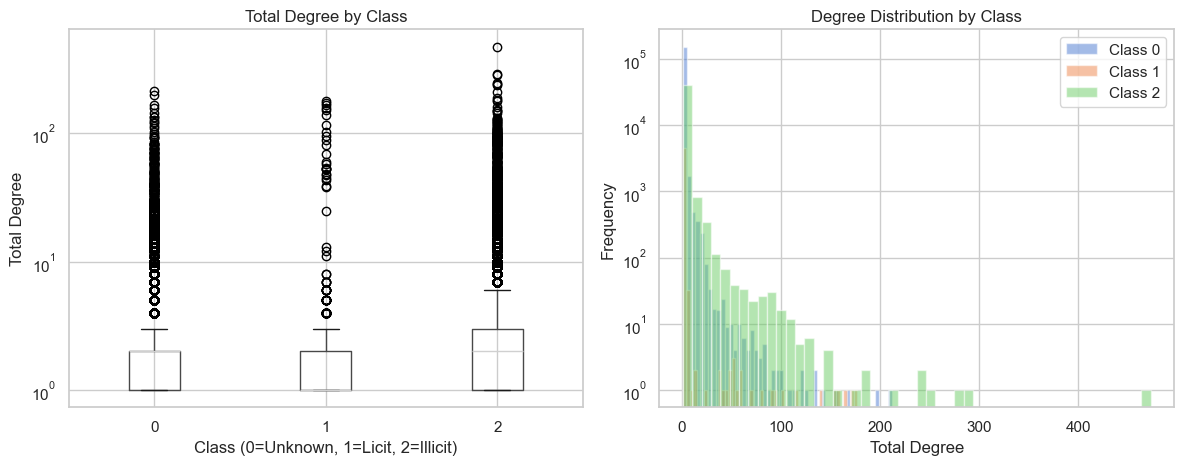

In [7]:
# Graph degree analysis
degree_by_class = elliptic_df.groupby('class')['total_degree'].describe()
print("Graph Degree Statistics by Class:")
display(degree_by_class)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
elliptic_df.boxplot(column='total_degree', by='class', ax=plt.gca())
plt.title('Total Degree by Class')
plt.suptitle('')  # Remove default title
plt.ylabel('Total Degree')
plt.xlabel('Class (0=Unknown, 1=Licit, 2=Illicit)')
plt.yscale('log')

plt.subplot(1, 2, 2)
for cls in [0, 1, 2]:
    data = elliptic_df[elliptic_df['class'] == cls]['total_degree']
    plt.hist(data, bins=50, alpha=0.5, label=f'Class {cls}')
plt.title('Degree Distribution by Class')
plt.xlabel('Total Degree')
plt.ylabel('Frequency')
plt.legend()
plt.yscale('log')

plt.tight_layout()
plt.show()

In [11]:
# Save processed Elliptic data
processed_file = 'elliptic_nodes_enhanced.csv'
loader.save_processed(elliptic_df, processed_file)

# Save metadata with proper type handling
metadata_file = PROCESSED_PATH / 'elliptic_metadata.json'
with open(metadata_file, 'w') as f:
    import json
    
    # Helper function to clean numpy types recursively
    def clean_for_json(obj):
        if isinstance(obj, dict):
            return {k: clean_for_json(v) for k, v in obj.items()}
        elif isinstance(obj, (list, tuple)):
            return [clean_for_json(item) for item in obj]
        elif isinstance(obj, (np.integer, np.int64)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64)):
            return float(obj)
        else:
            return obj
    
    # Clean the entire metadata structure
    metadata_clean = clean_for_json(loader.metadata['elliptic'])
    json.dump(metadata_clean, f, indent=2)
    
print(f'Metadata saved to: {metadata_file}')

Saved to: C:\Users\youss\Downloads\Flag_finance\data\processed\elliptic_nodes_enhanced.csv
Metadata saved to: C:\Users\youss\Downloads\Flag_finance\data\processed\elliptic_metadata.json


In [12]:
# Load PaySim dataset (2% sample for faster processing)
paysim_df = loader.load_paysim(sample_pct=0.02)

if paysim_df is not None:
    print(f"\n📊 PaySim Sample Shape: {paysim_df.shape}")
    print(f"Fraud Rate: {paysim_df['isFraud'].mean():.2%}")
    display(paysim_df.head())
else:
    print("⚠️ PaySim dataset not found. Skipping PaySim analysis.")


=== Loading PaySim Dataset ===

Loaded 127,252 transactions
Fraud rate: 0.14%
Transaction types: ['CASH_IN', 'PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT']

📊 PaySim Sample Shape: (127252, 22)
Fraud Rate: 0.14%


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,balanceDest_diff,balance_error_orig,balance_error_dest,hour,day,is_night,amount_log,amount_sqrt,amount_zscore,amount_outlier
3737323,278,CASH_IN,3.302184e+05,C632336343,20866.0,3.510844e+05,C834976624,4.524196e+05,1.222011e+05,0,...,-3.302184e+05,-6.604368e+05,-660436.812500,14,11,0,12.707513,574.646301,0.261668,0
264914,15,PAYMENT,1.164708e+04,C1264712553,30370.0,1.872292e+04,M215391829,0.000000e+00,0.000000e+00,0,...,0.000000e+00,0.000000e+00,-11647.080078,15,0,0,9.362897,107.921638,-0.294377,0
85647,10,CASH_IN,1.522642e+05,C1746846248,106589.0,2.588532e+05,C1607284477,2.013030e+05,4.903880e+04,0,...,-1.522642e+05,-3.045284e+05,-304528.437500,10,0,0,11.933379,390.210449,-0.048939,0
5899326,403,TRANSFER,1.551761e+06,C333676753,0.0,0.000000e+00,C1564353608,3.198360e+06,4.750120e+06,0,...,1.551760e+06,-1.551761e+06,-0.125000,19,16,0,14.254901,1245.696899,2.393787,1
2544263,206,CASH_IN,7.817230e+04,C813403091,2921331.5,2.999504e+06,C1091768874,4.158219e+05,3.376496e+05,0,...,-7.817231e+04,-1.563448e+05,-156344.609375,14,8,0,11.266684,279.593079,-0.178262,0


## 3. PaySim Mobile Money Analysis

Analysis of mobile money fraud patterns, transaction types, and temporal behavior.

PAYSIM MOBILE MONEY FRAUD ANALYSIS

💳 Transaction Type Distribution:


isFraud                   amount              
             sum      mean           mean           sum
type                                                   
CASH_IN        0  0.000000  168056.609375  4.747263e+09
CASH_OUT      75  0.001674  175224.328125  7.851276e+09
DEBIT          0  0.000000    6221.273926  4.896142e+06
PAYMENT        0  0.000000   13036.443359  5.580771e+08
TRANSFER      98  0.009244  922778.437500  9.782374e+09

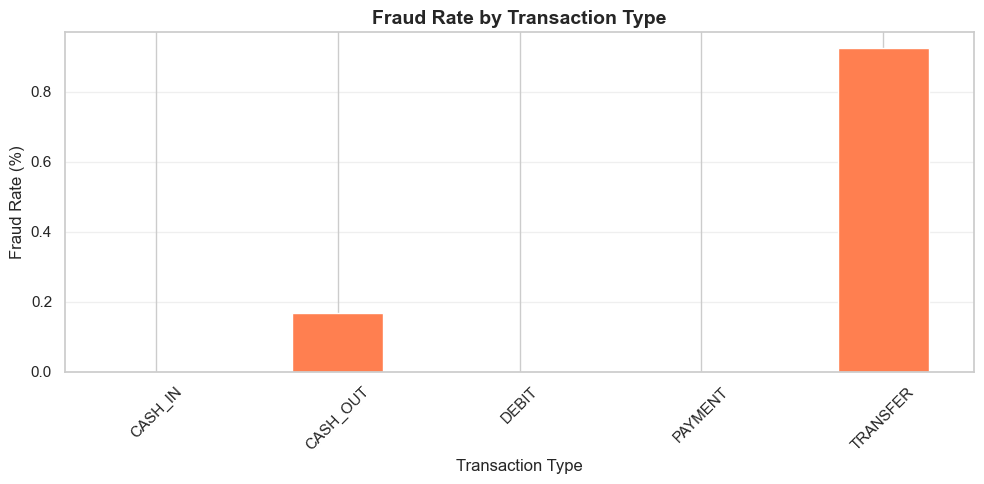

In [13]:
def advanced_paysim_analysis(df: pd.DataFrame):
    """Comprehensive PaySim analysis with visualizations."""
    
    if df is None:
        print("No PaySim data available for analysis.")
        return
    
    print("="*60)
    print("PAYSIM MOBILE MONEY FRAUD ANALYSIS")
    print("="*60)
    
    # Transaction type analysis
    print("\n💳 Transaction Type Distribution:")
    type_fraud = df.groupby('type').agg({
        'isFraud': ['sum', 'mean'],
        'amount': ['mean', 'sum']
    })
    display(type_fraud)
    
    # Fraud by transaction type
    fraud_by_type = df.groupby('type')['isFraud'].mean() * 100
    fraud_by_type.plot(kind='bar', color='coral', figsize=(10, 5))
    plt.title('Fraud Rate by Transaction Type', fontsize=14, fontweight='bold')
    plt.ylabel('Fraud Rate (%)')
    plt.xlabel('Transaction Type')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

if paysim_df is not None:
    advanced_paysim_analysis(paysim_df)

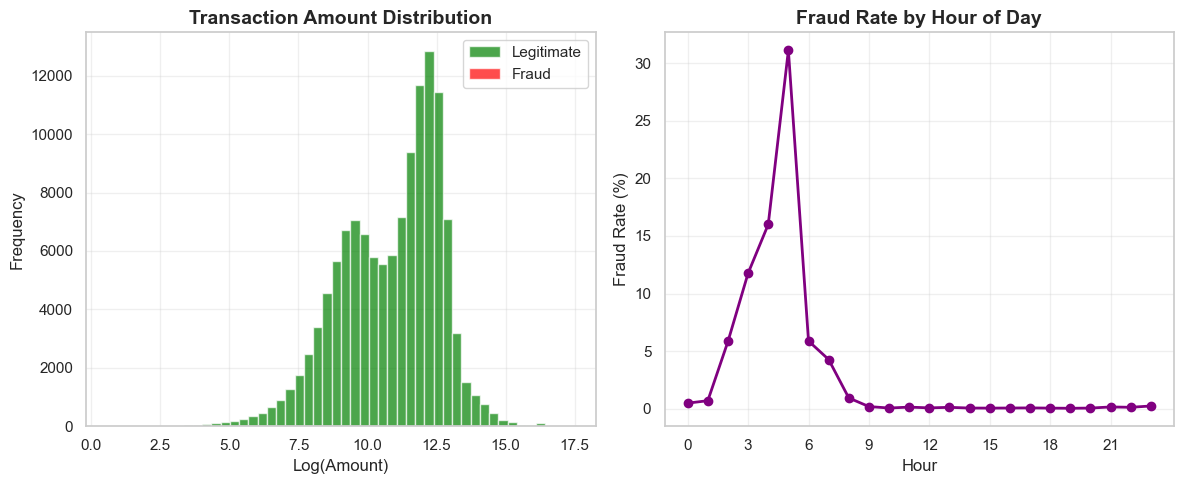

In [15]:
if paysim_df is not None:
    # Amount distribution comparison
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    paysim_df[paysim_df['isFraud'] == 0]['amount_log'].hist(bins=50, alpha=0.7, label='Legitimate', color='green')
    paysim_df[paysim_df['isFraud'] == 1]['amount_log'].hist(bins=50, alpha=0.7, label='Fraud', color='red')
    plt.title('Transaction Amount Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Log(Amount)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    hour_fraud = paysim_df.groupby('hour')['isFraud'].mean() * 100
    hour_fraud.plot(marker='o', color='purple', linewidth=2)
    plt.title('Fraud Rate by Hour of Day', fontsize=14, fontweight='bold')
    plt.xlabel('Hour')
    plt.ylabel('Fraud Rate (%)')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24, 3))
    
    plt.tight_layout()
    plt.show()

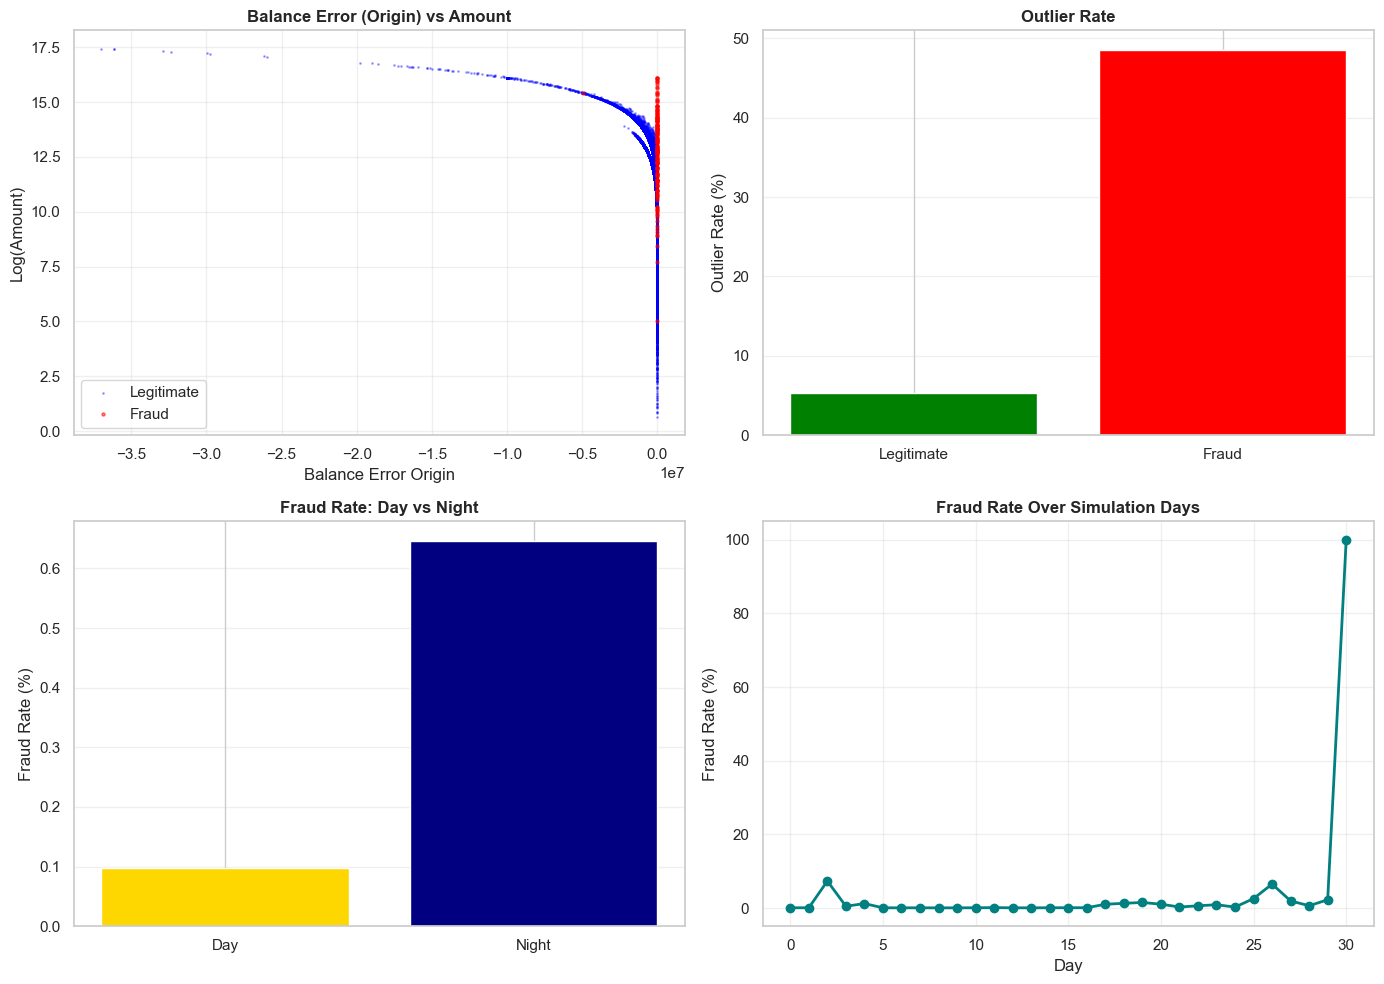

In [14]:
if paysim_df is not None:
    # Balance error analysis (fraud indicator)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Balance error origin
    axes[0, 0].scatter(paysim_df[paysim_df['isFraud'] == 0]['balance_error_orig'], 
                       paysim_df[paysim_df['isFraud'] == 0]['amount_log'],
                       alpha=0.3, s=1, label='Legitimate', color='blue')
    axes[0, 0].scatter(paysim_df[paysim_df['isFraud'] == 1]['balance_error_orig'], 
                       paysim_df[paysim_df['isFraud'] == 1]['amount_log'],
                       alpha=0.5, s=5, label='Fraud', color='red')
    axes[0, 0].set_title('Balance Error (Origin) vs Amount', fontweight='bold')
    axes[0, 0].set_xlabel('Balance Error Origin')
    axes[0, 0].set_ylabel('Log(Amount)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Outlier detection
    axes[0, 1].bar(['Legitimate', 'Fraud'], 
                   [paysim_df[paysim_df['isFraud'] == 0]['amount_outlier'].mean() * 100,
                    paysim_df[paysim_df['isFraud'] == 1]['amount_outlier'].mean() * 100],
                   color=['green', 'red'])
    axes[0, 1].set_title('Outlier Rate', fontweight='bold')
    axes[0, 1].set_ylabel('Outlier Rate (%)')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Night vs day fraud
    axes[1, 0].bar(['Day', 'Night'],
                   [paysim_df[paysim_df['is_night'] == 0]['isFraud'].mean() * 100,
                    paysim_df[paysim_df['is_night'] == 1]['isFraud'].mean() * 100],
                   color=['gold', 'navy'])
    axes[1, 0].set_title('Fraud Rate: Day vs Night', fontweight='bold')
    axes[1, 0].set_ylabel('Fraud Rate (%)')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Day of simulation fraud trend
    day_fraud = paysim_df.groupby('day')['isFraud'].mean() * 100
    axes[1, 1].plot(day_fraud.index, day_fraud.values, marker='o', color='teal', linewidth=2)
    axes[1, 1].set_title('Fraud Rate Over Simulation Days', fontweight='bold')
    axes[1, 1].set_xlabel('Day')
    axes[1, 1].set_ylabel('Fraud Rate (%)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [16]:
if paysim_df is not None:
    # Save processed PaySim data
    loader.save_processed(paysim_df, 'paysim_sample_enhanced.csv')
    
    # Generate and display comprehensive profile
    profile = loader.profile_dataset(paysim_df, 'PaySim')
    
    print("\n" + "="*60)
    print("DATASET PROFILE SUMMARY")
    print("="*60)
    print(f"\n📊 Dataset: {profile['name']}")
    print(f"   Shape: {profile['shape']}")
    print(f"   Memory: {profile['memory_usage_mb']:.2f} MB")
    print(f"   Duplicates: {profile['duplicate_rows']:,}")
    
    print(f"\n🏷️  Target Variable: {profile.get('target_column', 'N/A')}")
    if 'class_distribution' in profile:
        print("   Class Distribution:")
        for cls, count in profile['class_distribution'].items():
            pct = profile['class_balance'][cls] * 100
            print(f"      Class {cls}: {count:,} ({pct:.2f}%)")
    
    print(f"\n❓ Missing Values:")
    missing = {k: v for k, v in profile['missing_values'].items() if v > 0}
    if missing:
        for col, count in list(missing.items())[:5]:
            pct = profile['missing_pct'][col]
            print(f"      {col}: {count:,} ({pct:.2f}%)")
    else:
        print("      None")
    
    print(f"\n📈 Data Types:")
    for dtype, count in profile['dtypes'].items():
        print(f"      {dtype}: {count} columns")

Saved to: C:\Users\youss\Downloads\Flag_finance\data\processed\paysim_sample_enhanced.csv

DATASET PROFILE SUMMARY

📊 Dataset: PaySim
   Shape: (127252, 22)
   Memory: 25.97 MB
   Duplicates: 0

🏷️  Target Variable: isFraud
   Class Distribution:
      Class 0: 127,079 (99.86%)
      Class 1: 173 (0.14%)

❓ Missing Values:
      None

📈 Data Types:
      float32: 12 columns
      int32: 5 columns
      object: 2 columns
      int8: 2 columns
      category: 1 columns


In [17]:
# Generate comprehensive summary for all datasets
summary = {
    'exploration_timestamp': pd.Timestamp.now().isoformat(),
    'datasets_processed': list(loader.datasets.keys()),
    'metadata': loader.metadata,
    'paths': {
        'base': str(BASE_PATH),
        'raw': str(RAW_PATH),
        'processed': str(PROCESSED_PATH),
        'graphs': str(GRAPHS_PATH),
        'results': str(RESULTS_PATH)
    }
}

# Save exploration summary
summary_file = PROCESSED_PATH / 'exploration_summary.json'
with open(summary_file, 'w') as f:
    # Clean numpy types
    def clean_for_json(obj):
        if isinstance(obj, dict):
            return {k: clean_for_json(v) for k, v in obj.items()}
        elif isinstance(obj, (list, tuple)):
            return [clean_for_json(item) for item in obj]
        elif isinstance(obj, (np.integer, np.int64)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64)):
            return float(obj)
        else:
            return obj
    
    clean_summary = clean_for_json(summary)
    json.dump(clean_summary, f, indent=2)

print(f"\n✅ Exploration complete! Summary saved to: {summary_file}")
print(f"\n📦 Processed Files:")
for key in loader.datasets.keys():
    print(f"   - {key}")
print(f"\n📁 Output Directory: {PROCESSED_PATH}")


✅ Exploration complete! Summary saved to: C:\Users\youss\Downloads\Flag_finance\data\processed\exploration_summary.json

📦 Processed Files:
   - elliptic
   - elliptic_edges
   - paysim

📁 Output Directory: C:\Users\youss\Downloads\Flag_finance\data\processed


In [18]:
# Display final statistics
print("\n" + "="*70)
print("DATA EXPLORATION COMPLETE - KEY FINDINGS")
print("="*70)

if 'elliptic' in loader.metadata:
    m = loader.metadata['elliptic']
    print(f"\n🔹 Elliptic Bitcoin Dataset:")
    print(f"   Transactions: {m['n_transactions']:,}")
    print(f"   Features: {m['n_features']}")
    print(f"   Edges: {m['n_edges']:,}")
    print(f"   Time Steps: {m['n_time_steps']}")
    print(f"   Fraud Rate: {m['fraud_rate']*100:.2f}%")

if 'paysim' in loader.metadata:
    m = loader.metadata['paysim']
    print(f"\n🔹 PaySim Mobile Money Dataset:")
    print(f"   Transactions: {m['n_transactions']:,}")
    print(f"   Fraud Rate: {m['fraud_rate']*100:.2f}%")
    print(f"   Time Range: {m['time_range']}")

print(f"\n✅ All datasets processed and saved to: {PROCESSED_PATH}")
print("="*70)


DATA EXPLORATION COMPLETE - KEY FINDINGS

🔹 Elliptic Bitcoin Dataset:
   Transactions: 203,769
   Features: 165
   Edges: 234,355
   Time Steps: 49
   Fraud Rate: 20.62%

🔹 PaySim Mobile Money Dataset:
   Transactions: 127,252
   Fraud Rate: 0.14%
   Time Range: (1, 736)

✅ All datasets processed and saved to: C:\Users\youss\Downloads\Flag_finance\data\processed


In [19]:
# Quick data quality checks
print("🔍 Data Quality Checks:\n")

# Check Elliptic
if 'elliptic' in loader.datasets:
    df = loader.datasets['elliptic']
    print("Elliptic Dataset:")
    print(f"  ✓ No missing values in core features: {df[['txId', 'time_step', 'class']].isnull().sum().sum() == 0}")
    print(f"  ✓ All IDs unique: {df['txId'].nunique() == len(df)}")
    print(f"  ✓ Class values valid: {set(df['class'].unique()).issubset({0, 1, 2})}")

# Check PaySim
if 'paysim' in loader.datasets:
    df = loader.datasets['paysim']
    print("\nPaySim Dataset:")
    print(f"  ✓ No missing values: {df.isnull().sum().sum() == 0}")
    print(f"  ✓ Balance consistency: {(df['balance_error_orig'].abs() < 0.01).mean()*100:.1f}% within tolerance")
    print(f"  ✓ Valid transaction types: {df['type'].isin(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN']).all()}")

print("\n✅ Quality checks passed!")

🔍 Data Quality Checks:

Elliptic Dataset:
  ✓ No missing values in core features: True
  ✓ All IDs unique: True
  ✓ Class values valid: True

PaySim Dataset:
  ✓ No missing values: True
  ✓ Balance consistency: 18.6% within tolerance
  ✓ Valid transaction types: True

✅ Quality checks passed!


In [20]:
# Next Steps
print("\n" + "="*70)
print("NEXT STEPS")
print("="*70)
print("\n1. Graph Construction (Notebook 02)")
print("   → Build PyTorch Geometric graph from Elliptic data")
print("   → Create temporal edge features")
print("   → Apply feature normalization")
print("\n2. GNN Training (Notebook 03)")
print("   → Train baseline GNN models (GCN, GraphSAGE, GAT)")
print("   → Implement hybrid architectures")
print("   → Evaluate on temporal test splits")
print("\n3. Advanced Modeling (Notebooks 04-06)")
print("   → Contrastive pre-training")
print("   → LSTM sequence models")
print("   → Fusion architectures")
print("="*70)


NEXT STEPS

1. Graph Construction (Notebook 02)
   → Build PyTorch Geometric graph from Elliptic data
   → Create temporal edge features
   → Apply feature normalization

2. GNN Training (Notebook 03)
   → Train baseline GNN models (GCN, GraphSAGE, GAT)
   → Implement hybrid architectures
   → Evaluate on temporal test splits

3. Advanced Modeling (Notebooks 04-06)
   → Contrastive pre-training
   → LSTM sequence models
   → Fusion architectures
